# Hors thème : Clustering spatial pour La Réunion
- Clustering spatial par catégories
- Transformer les cluster en surfaciques

## Python stuff

In [1]:
import math
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from s3_utils import S3Manager

# Configs
_ = plt.style.use("ggplot")

## 1 - Récupération et préparation des données

In [2]:
# Chargement des éléments de connexion sur S3
s3_manager = S3Manager()
bucket = "fub-s3"

In [3]:
# Déjà executé
# s3_manager.download_from_s3(
#     bucket,
#     "data/DFG/2025/data_geo/données-carto-2025-06-03.geojson", 
#     "temp/données-carto-2025-06-03.geojson"
# )

In [4]:
# Données données internes
# gdf = s3_manager.load_geojson_from_s3(bucket, "data/DFG/2025/data_geo/données-carto-2025-06-03.geojson")
gdf = gpd.read_file("temp/données-carto-2025-06-03.geojson")

In [5]:
# Récupération par communes
communes = gpd.read_file("https://france-geojson.gregoiredavid.fr/repo/regions/la-reunion/communes-la-reunion.geojson")
communes = communes.to_crs(2975)

In [6]:
gdf = gdf.to_crs(communes.crs)
gdf_filtre = gpd.sjoin(gdf, communes, predicate="within", how="inner")
gdf_filtre = gdf_filtre.drop(columns=["index_right"])
gdf_filtre.rename(columns={"code": "code_commune", "nom": "nom_commune"}, inplace=True)

## 2 - Clustering spatial

### 2.1 - Contexte : Description des catégories en fonction du formulaire
Type de réponse : Geoloc + Commentaire

- Cat 60 : Cliquez sur la carte pour indiquer les 3 endroits où les conditions de circulation à vélo se sont le plus améliorées sur les deux dernières années.

- Cat 59 : Cliquez sur la carte pour indiquer les 3 endroits où le besoin en emplacements de stationnement sécurisé vous paraît le plus important.

- Cat 58 : Cliquez sur la carte pour indiquer les 3 endroits les plus problématiques pour se déplacer à vélo.

In [7]:
# Fonction de clustering
def dbscan_clustering(gdf: gpd.GeoDataFrame, dist_m=50):
    """
    Effectue un clustering spatial sur un GeoDataFrame.
    
    :param gdf: GeoDataFrame avec des géométries de points.
    :param dist_m : Distance en mètre entre les points pour former un cluster.
    :return: GeoDataFrame avec les clusters ajoutés.
    """
    # Step --> Reprojection
    gdf = gdf.to_crs(epsg=2975)
    print(f"✅ La projection du GeoDataFrame est : {gdf.crs}")

    # Step calcul log(n)
    min_sample = round(math.log(gdf.shape[0])) + 1
    print(f"ℹ️ La taille de l'échantillon est : {gdf.shape[0]}")
    print(f"ℹ️ Le nombre minimal d'échantillons pour le clustering est : {min_sample}")

    # Appliquer le clustering
    dbscan = DBSCAN(eps=dist_m, min_samples=min_sample, metric='euclidean')
    dbscan.fit(gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist())
    gdf["cluster_id"] = dbscan.labels_
    gdf = gdf[gdf["cluster_id"] != -1] # elimine le bruit

    print(f"ℹ️ Le nombre de clusters formés est : {gdf['cluster_id'].nunique()}")

    return gdf

### 2.2 - Cat 58

In [8]:
gdf_58 = gdf_filtre[gdf_filtre["cat"] == 58].copy()

In [9]:
gdf_58_cluster =  dbscan_clustering(gdf_58, dist_m=50)

✅ La projection du GeoDataFrame est : EPSG:2975
ℹ️ La taille de l'échantillon est : 3298
ℹ️ Le nombre minimal d'échantillons pour le clustering est : 9
ℹ️ Le nombre de clusters formés est : 16


In [10]:
gdf_58_cluster.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id
15,1dd437bc-ca64-4339-a55a-f1cb7061c755,58,ad76a504-6cb6-440e-adf5-535a65bc700a,None,POINT (322135.58 7678047.728),97415,Saint-Paul,0
16,d438c452-c60f-417e-8419-5c13dc219769,58,ad76a504-6cb6-440e-adf5-535a65bc700a,,POINT (322417.574 7678223.67),97415,Saint-Paul,13
2971,827e0835-9801-4066-9b69-38bb1acdc90a,58,211ac423-9781-4447-ae80-4ec2bf6094a9,Piste cyclable avec circulation piétonne dessu...,POINT (340796.748 7639185.023),97416,Saint-Pierre,6
11909,b0274c32-6eb5-4252-ab08-d6d2161501e4,58,2d353ec1-eb67-419b-b000-04f563ad79d5,None,POINT (341589.694 7640584.334),97416,Saint-Pierre,1
11911,2d3acad5-3808-4a8a-9ebb-c75f4cdbc1cf,58,2d353ec1-eb67-419b-b000-04f563ad79d5,"Circulation dense avant le pont, les véhicules...",POINT (342642.557 7640211.958),97416,Saint-Pierre,2


### 2.2 - Cat 59

In [11]:
gdf_59 = gdf_filtre[gdf_filtre["cat"] == 59].copy()

In [12]:
gdf_59_cluster =  dbscan_clustering(gdf_59, dist_m=50)

✅ La projection du GeoDataFrame est : EPSG:2975
ℹ️ La taille de l'échantillon est : 1843
ℹ️ Le nombre minimal d'échantillons pour le clustering est : 9
ℹ️ Le nombre de clusters formés est : 3


In [13]:
gdf_59_cluster.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id
2974,3fd92563-f8de-4a02-8e79-2e7c00e628a7,59,211ac423-9781-4447-ae80-4ec2bf6094a9,Au niveau de la plage de Saint-Pierre,POINT (341702.324 7639043.996),97416,Saint-Pierre,0
11912,9945d18c-4fa6-4fb7-a340-92ced906c0df,59,2d353ec1-eb67-419b-b000-04f563ad79d5,,POINT (341659.008 7639051.95),97416,Saint-Pierre,0
14849,526e3290-7a19-4655-a811-98a1d4e40a79,59,d370755f-61c4-4e92-9940-9b6967ba709f,,POINT (341625.269 7639034.38),97416,Saint-Pierre,0
26622,e623c711-e136-4d90-a40b-9c75157ad632,59,789cadff-c5e6-463c-87dc-070bdc2fcab4,,POINT (341639.202 7639054.638),97416,Saint-Pierre,0
46702,bf96d824-78cb-4f1b-873c-72f00de90320,59,4916a6fe-8545-4ca8-a53c-1f04073098a6,front de mer,POINT (341725.295 7639027.433),97416,Saint-Pierre,0


### 2.3 - Cat 60

In [14]:
gdf_60 = gdf_filtre[gdf_filtre["cat"] == 60].copy()

In [15]:
gdf_60_cluster =  dbscan_clustering(gdf_60, dist_m=50)

✅ La projection du GeoDataFrame est : EPSG:2975
ℹ️ La taille de l'échantillon est : 1360
ℹ️ Le nombre minimal d'échantillons pour le clustering est : 8
ℹ️ Le nombre de clusters formés est : 2


In [16]:
gdf_60_cluster.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id
17748,6ffdb37d-cc1e-4079-abcd-60efc62a6b0f,60,900a8e7d-59ef-433a-bcdf-d999522e50d6,,POINT (344188.653 7638552.476),97416,Saint-Pierre,0
38594,53675076-12c3-4235-a068-defccaf2ee01,60,c00078c8-37fb-4837-96f3-879f9dce19e1,création d'une voie vélo,POINT (340293.689 7689306.727),97411,Saint-Denis,1
46703,f89fb8ca-6a0f-4d96-9701-a5261662a034,60,4916a6fe-8545-4ca8-a53c-1f04073098a6,"direction grand bois, super",POINT (344182.676 7638522.565),97416,Saint-Pierre,0
52516,3e164e20-1ad5-49a6-8ea4-b0294b36aaf3,60,537c1539-e58b-4f99-9970-f65b95052df0,None,POINT (344282.501 7638524.157),97416,Saint-Pierre,0
57301,bfa3f65e-d414-4765-80a1-68830d030202,60,5a857bee-7722-4413-b34a-fd5396dce551,,POINT (340318.38 7689442.606),97411,Saint-Denis,1


## 3 - Classement par nombre de points par clusters

### 3.1 - Aggregation des clusters

In [17]:
# Compte des points par cluster
cluster_counts_58 = (
    gdf_58_cluster
    .groupby("cluster_id")
    .size()
    .reset_index(name="nb_points")
)
cluster_counts_58.sort_values(by="nb_points", ascending=False).head(3)

,cluster_id,nb_points
1,1,28
0,0,27
6,6,20


In [18]:
# Compte des points par cluster 
cluster_counts_59 = (
    gdf_59_cluster
    .groupby("cluster_id")
    .size()
    .reset_index(name="nb_points")
)
cluster_counts_59.sort_values(by="nb_points", ascending=False).head(3)

,cluster_id,nb_points
0,0,28
1,1,23
2,2,9


In [19]:
# Compte des points par cluster 
cluster_counts_60 = (
    gdf_60_cluster
    .groupby("cluster_id")
    .size()
    .reset_index(name="nb_points")
)
cluster_counts_60.sort_values(by="nb_points", ascending=False).head(3)

,cluster_id,nb_points
0,0,24
1,1,22


### 3.2 - Jointure pour affichage

In [20]:
gdf_58_cluster_nb = gdf_58_cluster.merge(cluster_counts_58, on="cluster_id")
gdf_58_cluster_nb.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id,nb_points
0,1dd437bc-ca64-4339-a55a-f1cb7061c755,58,ad76a504-6cb6-440e-adf5-535a65bc700a,None,POINT (322135.58 7678047.728),97415,Saint-Paul,0,27
1,d438c452-c60f-417e-8419-5c13dc219769,58,ad76a504-6cb6-440e-adf5-535a65bc700a,,POINT (322417.574 7678223.67),97415,Saint-Paul,13,9
2,827e0835-9801-4066-9b69-38bb1acdc90a,58,211ac423-9781-4447-ae80-4ec2bf6094a9,Piste cyclable avec circulation piétonne dessu...,POINT (340796.748 7639185.023),97416,Saint-Pierre,6,20
3,b0274c32-6eb5-4252-ab08-d6d2161501e4,58,2d353ec1-eb67-419b-b000-04f563ad79d5,None,POINT (341589.694 7640584.334),97416,Saint-Pierre,1,28
4,2d3acad5-3808-4a8a-9ebb-c75f4cdbc1cf,58,2d353ec1-eb67-419b-b000-04f563ad79d5,"Circulation dense avant le pont, les véhicules...",POINT (342642.557 7640211.958),97416,Saint-Pierre,2,13


In [21]:
gdf_59_cluster_nb = gdf_59_cluster.merge(cluster_counts_59, on="cluster_id")
gdf_59_cluster_nb.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id,nb_points
0,3fd92563-f8de-4a02-8e79-2e7c00e628a7,59,211ac423-9781-4447-ae80-4ec2bf6094a9,Au niveau de la plage de Saint-Pierre,POINT (341702.324 7639043.996),97416,Saint-Pierre,0,28
1,9945d18c-4fa6-4fb7-a340-92ced906c0df,59,2d353ec1-eb67-419b-b000-04f563ad79d5,,POINT (341659.008 7639051.95),97416,Saint-Pierre,0,28
2,526e3290-7a19-4655-a811-98a1d4e40a79,59,d370755f-61c4-4e92-9940-9b6967ba709f,,POINT (341625.269 7639034.38),97416,Saint-Pierre,0,28
3,e623c711-e136-4d90-a40b-9c75157ad632,59,789cadff-c5e6-463c-87dc-070bdc2fcab4,,POINT (341639.202 7639054.638),97416,Saint-Pierre,0,28
4,bf96d824-78cb-4f1b-873c-72f00de90320,59,4916a6fe-8545-4ca8-a53c-1f04073098a6,front de mer,POINT (341725.295 7639027.433),97416,Saint-Pierre,0,28


In [22]:
gdf_60_cluster_nb = gdf_60_cluster.merge(cluster_counts_60, on="cluster_id")
gdf_60_cluster_nb.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id,nb_points
0,6ffdb37d-cc1e-4079-abcd-60efc62a6b0f,60,900a8e7d-59ef-433a-bcdf-d999522e50d6,,POINT (344188.653 7638552.476),97416,Saint-Pierre,0,24
1,53675076-12c3-4235-a068-defccaf2ee01,60,c00078c8-37fb-4837-96f3-879f9dce19e1,création d'une voie vélo,POINT (340293.689 7689306.727),97411,Saint-Denis,1,22
2,f89fb8ca-6a0f-4d96-9701-a5261662a034,60,4916a6fe-8545-4ca8-a53c-1f04073098a6,"direction grand bois, super",POINT (344182.676 7638522.565),97416,Saint-Pierre,0,24
3,3e164e20-1ad5-49a6-8ea4-b0294b36aaf3,60,537c1539-e58b-4f99-9970-f65b95052df0,None,POINT (344282.501 7638524.157),97416,Saint-Pierre,0,24
4,bfa3f65e-d414-4765-80a1-68830d030202,60,5a857bee-7722-4413-b34a-fd5396dce551,,POINT (340318.38 7689442.606),97411,Saint-Denis,1,22


### 3.3 - Jointure score par taux de participation

#### 3.3.1 - Cluster 58

In [23]:
# Compter les points par communes
cluster_taux_58 = (
    gdf_58_cluster_nb
    .groupby("nom_commune")
    .size()
    .reset_index(name="total_commune")
)
cluster_taux_58.sort_values(by="total_commune", ascending=False).head(3)

,nom_commune,total_commune
3,Saint-Pierre,103
2,Saint-Paul,78
0,Saint-Denis,30


In [24]:
gdf_58_cluster_nb = gdf_58_cluster_nb.merge(cluster_taux_58, on="nom_commune")
gdf_58_cluster_nb["taux_points"] =  round((gdf_58_cluster_nb["nb_points"] / gdf_58_cluster_nb["total_commune"]) * 100, 2)
gdf_58_cluster_nb.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id,nb_points,total_commune,taux_points
0,1dd437bc-ca64-4339-a55a-f1cb7061c755,58,ad76a504-6cb6-440e-adf5-535a65bc700a,None,POINT (322135.58 7678047.728),97415,Saint-Paul,0,27,78,34.62
1,d438c452-c60f-417e-8419-5c13dc219769,58,ad76a504-6cb6-440e-adf5-535a65bc700a,,POINT (322417.574 7678223.67),97415,Saint-Paul,13,9,78,11.54
2,827e0835-9801-4066-9b69-38bb1acdc90a,58,211ac423-9781-4447-ae80-4ec2bf6094a9,Piste cyclable avec circulation piétonne dessu...,POINT (340796.748 7639185.023),97416,Saint-Pierre,6,20,103,19.42
3,b0274c32-6eb5-4252-ab08-d6d2161501e4,58,2d353ec1-eb67-419b-b000-04f563ad79d5,None,POINT (341589.694 7640584.334),97416,Saint-Pierre,1,28,103,27.18
4,2d3acad5-3808-4a8a-9ebb-c75f4cdbc1cf,58,2d353ec1-eb67-419b-b000-04f563ad79d5,"Circulation dense avant le pont, les véhicules...",POINT (342642.557 7640211.958),97416,Saint-Pierre,2,13,103,12.62


#### 3.3.2 - Cluster 59 

In [25]:
# Compter les points par communes
cluster_taux_59 = (
    gdf_59_cluster_nb
    .groupby("nom_commune")
    .size()
    .reset_index(name="total_commune")
)
cluster_taux_59.sort_values(by="total_commune", ascending=False).head(3)

,nom_commune,total_commune
2,Saint-Pierre,28
0,Saint-Denis,23
1,Saint-Joseph,9


In [26]:
gdf_59_cluster_nb = gdf_59_cluster_nb.merge(cluster_taux_59, on="nom_commune")
gdf_59_cluster_nb["taux_points"] =  round((gdf_59_cluster_nb["nb_points"] / gdf_59_cluster_nb["total_commune"]) * 100, 2)
gdf_59_cluster_nb.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id,nb_points,total_commune,taux_points
0,3fd92563-f8de-4a02-8e79-2e7c00e628a7,59,211ac423-9781-4447-ae80-4ec2bf6094a9,Au niveau de la plage de Saint-Pierre,POINT (341702.324 7639043.996),97416,Saint-Pierre,0,28,28,100.0
1,9945d18c-4fa6-4fb7-a340-92ced906c0df,59,2d353ec1-eb67-419b-b000-04f563ad79d5,,POINT (341659.008 7639051.95),97416,Saint-Pierre,0,28,28,100.0
2,526e3290-7a19-4655-a811-98a1d4e40a79,59,d370755f-61c4-4e92-9940-9b6967ba709f,,POINT (341625.269 7639034.38),97416,Saint-Pierre,0,28,28,100.0
3,e623c711-e136-4d90-a40b-9c75157ad632,59,789cadff-c5e6-463c-87dc-070bdc2fcab4,,POINT (341639.202 7639054.638),97416,Saint-Pierre,0,28,28,100.0
4,bf96d824-78cb-4f1b-873c-72f00de90320,59,4916a6fe-8545-4ca8-a53c-1f04073098a6,front de mer,POINT (341725.295 7639027.433),97416,Saint-Pierre,0,28,28,100.0


#### 3.3.3 - Cluster 60

In [27]:
# Compter les points par communes
cluster_taux_60 = (
    gdf_60_cluster_nb
    .groupby("nom_commune")
    .size()
    .reset_index(name="total_commune")
)
cluster_taux_60.sort_values(by="total_commune", ascending=False).head(3)

,nom_commune,total_commune
1,Saint-Pierre,24
0,Saint-Denis,22


In [28]:
gdf_60_cluster_nb = gdf_60_cluster_nb.merge(cluster_taux_60, on="nom_commune")
gdf_60_cluster_nb["taux_points"] =  round((gdf_60_cluster_nb["nb_points"] / gdf_60_cluster_nb["total_commune"]) * 100, 2)
gdf_60_cluster_nb.head()

,uid,cat,uid_reponse,description,geometry,code_commune,nom_commune,cluster_id,nb_points,total_commune,taux_points
0,6ffdb37d-cc1e-4079-abcd-60efc62a6b0f,60,900a8e7d-59ef-433a-bcdf-d999522e50d6,,POINT (344188.653 7638552.476),97416,Saint-Pierre,0,24,24,100.0
1,53675076-12c3-4235-a068-defccaf2ee01,60,c00078c8-37fb-4837-96f3-879f9dce19e1,création d'une voie vélo,POINT (340293.689 7689306.727),97411,Saint-Denis,1,22,22,100.0
2,f89fb8ca-6a0f-4d96-9701-a5261662a034,60,4916a6fe-8545-4ca8-a53c-1f04073098a6,"direction grand bois, super",POINT (344182.676 7638522.565),97416,Saint-Pierre,0,24,24,100.0
3,3e164e20-1ad5-49a6-8ea4-b0294b36aaf3,60,537c1539-e58b-4f99-9970-f65b95052df0,None,POINT (344282.501 7638524.157),97416,Saint-Pierre,0,24,24,100.0
4,bfa3f65e-d414-4765-80a1-68830d030202,60,5a857bee-7722-4413-b34a-fd5396dce551,,POINT (340318.38 7689442.606),97411,Saint-Denis,1,22,22,100.0


### 3.4 - Enveloppe convexe 
> Passage des données en points vers des données surfacique

#### 3.4.1 - Cluster 58

In [29]:
# Groupement par cluster
gdf_58_cluster_surf = gdf_58_cluster_nb.groupby('cluster_id')

# Créaction de l'enveloppe convex
polygons_58 = gdf_58_cluster_surf.geometry.apply(lambda x: x.union_all().convex_hull)
gdf_polygons_58 = gpd.GeoDataFrame(polygons_58, geometry=polygons_58, crs=gdf_58_cluster_nb.crs).reset_index()
gdf_polygons_58.head()

,cluster_id,geometry
0,0,"POLYGON ((322118.491 7677995.638, 322113.601 7..."
1,1,"POLYGON ((341572.74 7640502.737, 341480.392 76..."
2,2,"POLYGON ((342689.175 7640181.378, 342640.465 7..."
3,3,"POLYGON ((340969.03 7688848.12, 340907.427 768..."
4,4,"POLYGON ((346181.642 7688388.445, 346142.083 7..."


In [30]:
gdf_58_cluster_s = gdf_polygons_58.merge(gdf_58_cluster_nb, on='cluster_id', how='left', suffixes=('', '_point'))
gdf_58_cluster_s[gdf_58_cluster_s["geometry_point"].notna()]
gdf_58_cluster_s.drop(columns='geometry_point', inplace=True)
gdf_58_cluster_s = gdf_58_cluster_s.drop_duplicates("cluster_id")
print(gdf_58_cluster_s.shape)
gdf_58_cluster_s.head()

(16, 11)


,cluster_id,geometry,uid,cat,uid_reponse,description,code_commune,nom_commune,nb_points,total_commune,taux_points
0,0,"POLYGON ((322118.491 7677995.638, 322113.601 7...",1dd437bc-ca64-4339-a55a-f1cb7061c755,58,ad76a504-6cb6-440e-adf5-535a65bc700a,None,97415,Saint-Paul,27,78,34.62
27,1,"POLYGON ((341572.74 7640502.737, 341480.392 76...",b0274c32-6eb5-4252-ab08-d6d2161501e4,58,2d353ec1-eb67-419b-b000-04f563ad79d5,None,97416,Saint-Pierre,28,103,27.18
55,2,"POLYGON ((342689.175 7640181.378, 342640.465 7...",2d3acad5-3808-4a8a-9ebb-c75f4cdbc1cf,58,2d353ec1-eb67-419b-b000-04f563ad79d5,"Circulation dense avant le pont, les véhicules...",97416,Saint-Pierre,13,103,12.62
68,3,"POLYGON ((340969.03 7688848.12, 340907.427 768...",ba9ebf58-37f2-48c6-862e-df3f4faab2a5,58,ef01fcb3-4f73-40f9-9d76-7a7476985c4b,None,97411,Saint-Denis,17,30,56.67
85,4,"POLYGON ((346181.642 7688388.445, 346142.083 7...",36bfc295-4c20-4fa2-908f-01fa2f5d9384,58,1ad8deda-3ae0-45e0-852b-390e48e4751a,Croisement entre la piste cyclable et les voie...,97418,Sainte-Marie,10,10,100.00


#### 3.4.2 - Cluster 59 

In [31]:
# Groupement par cluster
gdf_59_cluster_surf = gdf_59_cluster_nb.groupby('cluster_id')

# Créaction de l'enveloppe convex
polygons_59 = gdf_59_cluster_surf.geometry.apply(lambda x: x.union_all().convex_hull)
gdf_polygons_59 = gpd.GeoDataFrame(polygons_59, geometry=polygons_59, crs=gdf_59_cluster_nb.crs).reset_index()
gdf_polygons_59.head()

,cluster_id,geometry
0,0,"POLYGON ((341773.277 7638985.015, 341603.422 7..."
1,1,"POLYGON ((338575.248 7690634.06, 338566.679 76..."
2,2,"POLYGON ((356872.139 7635277.326, 356816.475 7..."


In [32]:
gdf_59_cluster_s = gdf_polygons_59.merge(gdf_59_cluster_nb, on='cluster_id', how='left', suffixes=('', '_point'))
gdf_59_cluster_s[gdf_59_cluster_s["geometry_point"].notna()]
gdf_59_cluster_s.drop(columns='geometry_point', inplace=True)
gdf_59_cluster_s = gdf_59_cluster_s.drop_duplicates("cluster_id")
print(gdf_59_cluster_s.shape)
gdf_59_cluster_s.head()

(3, 11)


,cluster_id,geometry,uid,cat,uid_reponse,description,code_commune,nom_commune,nb_points,total_commune,taux_points
0,0,"POLYGON ((341773.277 7638985.015, 341603.422 7...",3fd92563-f8de-4a02-8e79-2e7c00e628a7,59,211ac423-9781-4447-ae80-4ec2bf6094a9,Au niveau de la plage de Saint-Pierre,97416,Saint-Pierre,28,28,100.0
28,1,"POLYGON ((338575.248 7690634.06, 338566.679 76...",248ad03d-0f89-4070-8daa-1a27ef1e1ed1,59,39c6aaeb-7b96-4abb-8127-0e20e555b8c2,,97411,Saint-Denis,23,23,100.0
51,2,"POLYGON ((356872.139 7635277.326, 356816.475 7...",eff7ac10-c596-4c4a-b69b-3f8d50a5732c,59,df8d57b3-e896-4459-82ca-af0fbce65bdd,Mairie/Eglise,97412,Saint-Joseph,9,9,100.0


#### 3.4.3 - Cluster 60

In [33]:
# Groupement par cluster
gdf_60_cluster_surf = gdf_60_cluster_nb.groupby('cluster_id')

# Créaction de l'enveloppe convex
polygons_60 = gdf_60_cluster_surf.geometry.apply(lambda x: x.union_all().convex_hull)
gdf_polygons_60 = gpd.GeoDataFrame(polygons_60, geometry=polygons_60, crs=gdf_60_cluster_nb.crs).reset_index()
gdf_polygons_60.head()

,cluster_id,geometry
0,0,"POLYGON ((344253.238 7638512.453, 344100.143 7..."
1,1,"POLYGON ((340290.116 7689300.083, 340291.114 7..."


In [34]:
gdf_60_cluster_s = gdf_polygons_60.merge(gdf_60_cluster_nb, on='cluster_id', how='left', suffixes=('', '_point'))
gdf_60_cluster_s[gdf_60_cluster_s["geometry_point"].notna()]
gdf_60_cluster_s.drop(columns='geometry_point', inplace=True)
gdf_60_cluster_s = gdf_60_cluster_s.drop_duplicates("cluster_id")
print(gdf_60_cluster_s.shape)
gdf_60_cluster_s.head()

(2, 11)


,cluster_id,geometry,uid,cat,uid_reponse,description,code_commune,nom_commune,nb_points,total_commune,taux_points
0,0,"POLYGON ((344253.238 7638512.453, 344100.143 7...",6ffdb37d-cc1e-4079-abcd-60efc62a6b0f,60,900a8e7d-59ef-433a-bcdf-d999522e50d6,,97416,Saint-Pierre,24,24,100.0
24,1,"POLYGON ((340290.116 7689300.083, 340291.114 7...",53675076-12c3-4235-a068-defccaf2ee01,60,c00078c8-37fb-4837-96f3-879f9dce19e1,création d'une voie vélo,97411,Saint-Denis,22,22,100.0


## 4 - Visualisation d'un des clusters

In [35]:
viz_data_58 = gdf_58_cluster_s[gdf_58_cluster_s["nom_commune"].str.contains('Saint-Pierre')]

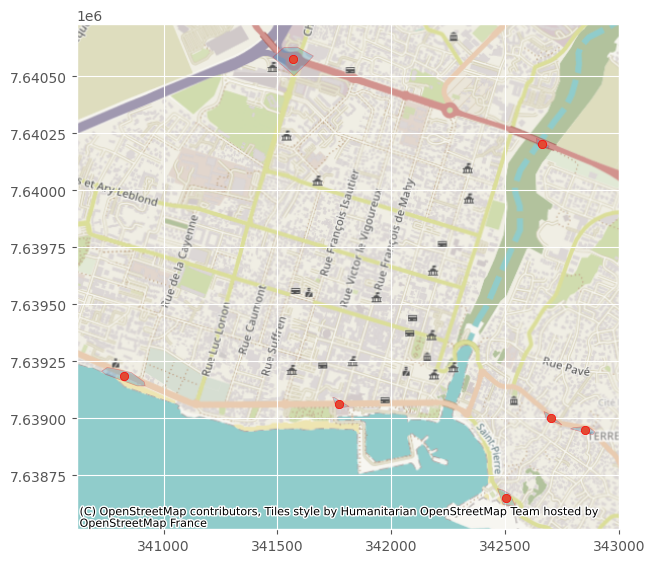

In [36]:
fig, ax = plt.subplots(figsize=(7, 7))
viz_data_58.plot(ax=ax, alpha=0.3, edgecolor='red')
viz_data_58.centroid.plot(ax=ax, alpha=1, edgecolor='red')
_ = ctx.add_basemap(ax, crs=viz_data_58.crs.to_string())
plt.show()

## 5 - Export des données

In [37]:
gdf_58_cluster_s_export = gdf_58_cluster_s.to_crs(epsg=2975).copy()
gdf_59_cluster_s_export = gdf_59_cluster_s.to_crs(epsg=2975).copy()
gdf_60_cluster_s_export = gdf_60_cluster_s.to_crs(epsg=2975).copy()

In [38]:
print("CRS gdf_58_cluster_nb:", gdf_58_cluster_s_export.crs)
print("CRS gdf_59_cluster_nb:", gdf_59_cluster_s_export.crs)
print("CRS gdf_60_cluster_nb:", gdf_60_cluster_s_export.crs)

CRS gdf_58_cluster_nb: EPSG:2975
CRS gdf_59_cluster_nb: EPSG:2975
CRS gdf_60_cluster_nb: EPSG:2975


In [39]:
gdf_58_cluster_s_export.to_file("temp/cluster_cat_58_la_reunion.geojson", driver="GeoJSON")
gdf_59_cluster_s_export.to_file("temp/cluster_cat_59_la_reunion.geojson", driver="GeoJSON")
gdf_60_cluster_s_export.to_file("temp/cluster_cat_60_la_reunion.geojson", driver="GeoJSON")

-- END --